Setup

In [ ]:
%%capture
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip -O msrc_objcategimagedatabase_v1.zip
!unzip msrc_objcategimagedatabase_v1.zip
!rm msrc_objcategimagedatabase_v1.zip

In [ ]:
!pip install scikit-image==0.24.0 --upgrade

Example images

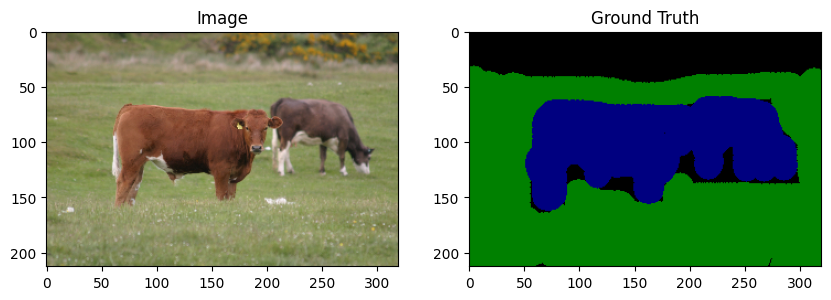

In [6]:
from skimage import io, segmentation, color, measure
from skimage import graph
import numpy as np
import matplotlib.pyplot as plt

# Load the image and its ground truth
image = io.imread('/content/MSRC_ObjCategImageDatabase_v1/1_16_s.bmp')
ground_truth = io.imread('/content/MSRC_ObjCategImageDatabase_v1/1_16_s_GT.bmp')

# show images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(ground_truth)
ax[1].set_title('Ground Truth')
plt.show()


Generate Superpixels using SLIC

In [8]:
from skimage.util import img_as_ubyte, img_as_float, img_as_uint, img_as_float64

compactness=30 #explain
n_segments=100 #Explain
labels = segmentation.slic(image, compactness=compactness, n_segments=n_segments, enforce_connectivity=True)
image_with_boundaries = segmentation.mark_boundaries(image, labels, color=(0, 0, 0))
image_with_boundaries = img_as_ubyte(image_with_boundaries)
pixel_labels = color.label2rgb(labels, image_with_boundaries, kind='avg', bg_label=0)


Apply Ncut

In [9]:
# using the labels found with the superpixeled image
# compute the Region Adjacency Graph using mean colors
g = graph.rag_mean_color(image, labels, mode='similarity')

# perform Normalized Graph cut on the Region Adjacency Graph
labels2 = graph.cut_normalized(labels, g)
segmented_image = color.label2rgb(labels2, image, kind='avg')

Show result

Text(0.5, 1.0, 'Segmented image (normalized cut)')

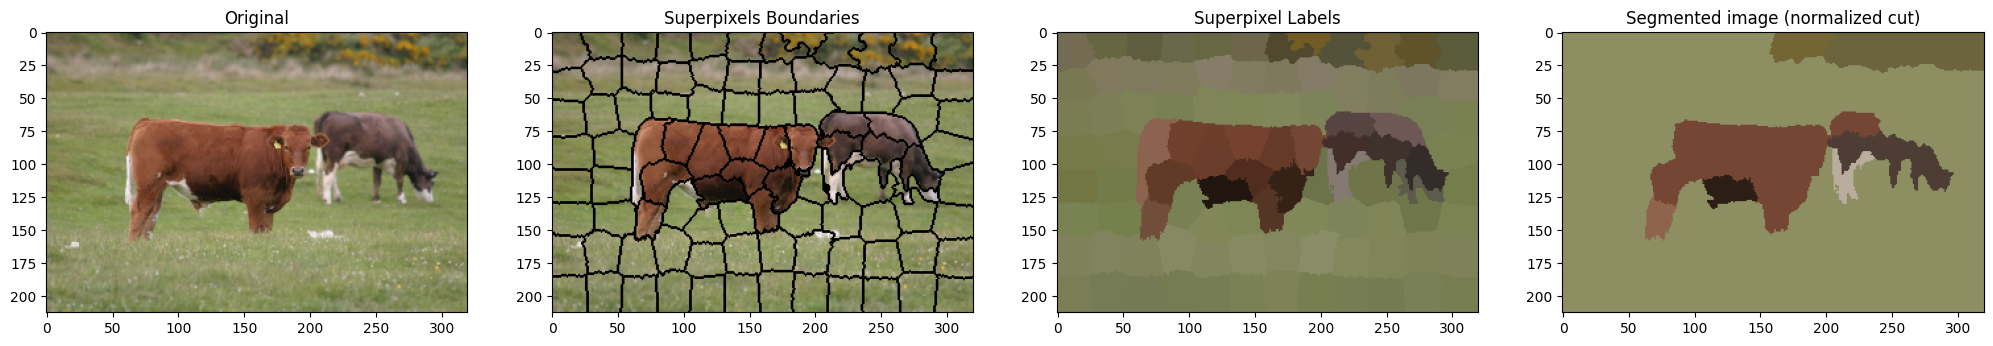

In [11]:
f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(25, 20))

axarr[0].imshow(image)
axarr[0].set_title("Original")

#plot boundaries
axarr[1].imshow(image_with_boundaries)
axarr[1].set_title("Superpixels Boundaries")

#plot labels
axarr[2].imshow(pixel_labels)
axarr[2].set_title('Superpixel Labels')

#compute segmentation
axarr[3].imshow(segmented_image)
axarr[3].set_title('Segmented image (normalized cut)')

Metrics

To apply these metrics we need that the prediction and the groundtruth image have the same lables. To compute the lables we compute a mask on the groundtruth and on the prediction assigning an id to each color found on the image

Segmentation using ncut however may find more regions than groundtruth, this will lower the accuracy.

In [13]:
def compute_mask(image):
  color_dict = {}

  # Get the shape of the image
  height,width,_ = image.shape

  # Create an empty array for labels
  labels = np.zeros((height,width),dtype=int)
  id=0
  # Loop over each pixel
  for i in range(height):
      for j in range(width):
          # Get the color of the pixel
          color = tuple(image[i,j])
          # Check if it is in the dictionary
          if color in color_dict:
              # Assign the label from the dictionary
              labels[i,j] = color_dict[color]
          else:
              color_dict[color]=id
              labels[i,j] = id
              id+=1

  return(labels)

In [14]:
def show_img(prediction, groundtruth):
  f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

  axarr[0].imshow(groundtruth)
  axarr[0].set_title("groundtruth")
  axarr[1].imshow(prediction)
  axarr[1].set_title(f"prediction")

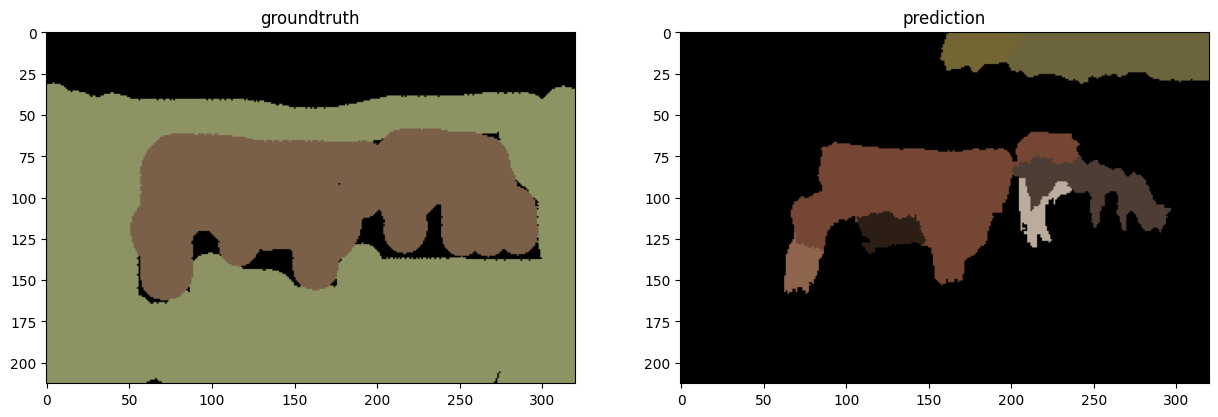

In [15]:
prediction_mask = compute_mask(segmented_image)
groundtruth_mask = compute_mask(ground_truth)

#usign the original image as baseline to convert from labels to color
prediction_img = color.label2rgb(prediction_mask, image, kind='avg', bg_label=0)
groundtruth_img = color.label2rgb(groundtruth_mask, image, kind='avg', bg_label=0)

show_img(prediction_img, groundtruth_img)

In [16]:
from sklearn.metrics import jaccard_score
from skimage.metrics import structural_similarity as ssim

ssim_score = ssim(prediction_img, groundtruth_img, channel_axis=2)
print(f"SSIM SCORE: {ssim_score}")

jac = jaccard_score(y_true=np.asarray(groundtruth_mask).flatten(),
                        y_pred=np.asarray(prediction_mask).flatten(),
                        average = None)

# compute mean IoU score across all classes
mean_iou = np.mean(jac)
print(f"Mean IoU: {mean_iou}")

SSIM SCORE: 0.20725207005735458
Mean IoU: 0.02233511601978956
